# Exercise 5 (RBM)

21_centuryboys

## Importing packages

In [22]:
import numpy as np
import random
import csv
import matplotlib.pyplot as plt
from numpy import exp
#%matplotlib inline


## Importing data

In [2]:
#load clean data
q=0.0
fname='DATA/dataRBM_q'+str(q)+'.csv'
v = np.loadtxt(fname, delimiter = ',', dtype = int)

N = len(v)
L = len(v[0])


#load corrupted data
q=0.1
fname='DATA/dataRBM_q'+str(q)+'.csv'
vc = np.loadtxt(fname, delimiter = ',', dtype = int)

Nc = len(vc)
Lc = len(vc[0])


#True if you want to change from [0,1] to [-1,1]
SPINS = False
if SPINS:
    vmin = -1
    GAP = 2
    v = 2*v - 1
    vc = 2*vc - 1
else:
    vmin = 0
    GAP = 1
    
# store initial values
v0 = np.copy(v)
vc0 = np.copy(vc)

#print the percentage of uncorrupted data
mat = (v0==vc0)
summ = 0
for i in range(N):summ += (mat[i]).sum()
print("Percentage of uncorrupted data:",summ*100/(N*L),"%")



Percentage of uncorrupted data: 90.01625 %


## Utility functions
### Functions to plot weights and generate layers from weights

In [3]:
#utility functions

def create_coord(np, x0):
    x = [x0] * np
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1.) - 0.5
    return (x,y)

def mycolor(val):
    if val>0:
        return 'red'
    elif val<0:
        return 'blue'
    return 'black'

def plotgraph(epoch, w, a, b, L, M, x1, x2, y1, y2):
    A = 2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]), (y1[i],y2[j]), mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw = A*np.abs(w[i][j]))
    A = 300./(a.max() + b.max())
    for i in range(L):
        plt.scatter(x1[i],y1[i], s=A*np.abs(a[i]), zorder=2, c = mycolor(a[i]))
    for j in range(M):
        plt.scatter(x2[j],y2[j], s=A*np.abs(b[j]), zorder=2, c = mycolor(b[j]))
    plt.title(f'>0 red, <0 blue, epoch = {epoch}')
    plt.show()
    
def activate(v_in, wei, bias, DE, info=False):
    act = np.dot(v_in,wei) + bias
    prob = 1. / (1. + exp(-DE*act))
    n = len(act)
    v_out = np.full(n, vmin)
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print('input=', v_in)
        print('act=', act)
        print('prob=', prob)
        print('out=', v_out)
    return v_out

def accuracy(v0, vc0, w, a, b, GAPv = GAP, GAPh = GAP):

    v1c = []
    for n in range(N):
        h = activate(vc0[n],w,b,GAPh)
        v1c.append(activate(h,w.T,a,GAPv))
    v1c = np.array(v1c)

    cr_accuracy = 1-((v1c*2 - 1)*(v0*2 - 1) == -1).sum()/(N*L)
    
    return cr_accuracy


### Function to train

In [4]:
def rbm(v, vc0, v0, M = 3, l_rate = 1.0, alpha = 0.05, mini = 500, nepoch=50, GAPv = GAP, GAPh = GAP, genGAPh = GAP, genGAPv = GAP):

# v: data for training
# vc: data corrupted
# v0: clean data
# M: hidden neurons
# mini: minibatch size
# l_rate: starting learning rate
# alpha: coefficent alpha of power decreasing of learning rate
# GAPv: 1/T during the hidden neurons generation in training procedure
# GAPh: 1/T during the visible neurons generation in training procedure
# genGAPv: 1/T during the hidden neurons generation in training procedure
# genGAPh: 1/T during the visible neurons generation in training procedure

    np.random.seed(12345)
    N = len(v)
    L = len(v[0])
    
    sigma = np.sqrt(4. / float(len(v[0]) + M))
    
    w = sigma * (2*np.random.rand(L,M) - 1)
    a = sigma * (2*np.random.rand(L) - 1)
    b = np.zeros(M)
    dw2 = []
    
    (x1,y1) = create_coord(L,0)
    (x2,y2) = create_coord(M,1)
    
    np.random.seed(12345)

    l_rate = 1.0
    # minibatches
    m = 0

    for epoch in range(1,1+nepoch):
        for n in range(N):
            if m == 0:
                # initialize
                v_data, v_model = np.zeros(L), np.zeros(L)
                h_data, h_model = np.zeros(M), np.zeros(M)
                vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            
            # positive CD phase
            h = activate(v[n],w,b,GAPh)
            # negative CD phase
            vf = activate(h,w.T,a,GAPv)
            # positive CD phase nr2
            hf = activate(vf,w,b,GAPh)
        
            v_data += v[n]
            v_model += vf
            h_data += h
            h_model += hf
            #maybe regenarate data for computing vh_model
            vh_data += np.outer(v[n].T, h)
            vh_model += np.outer(vf.T, hf)
        
            m += 1
        
            if m == mini:
                C = l_rate/mini
                #maybe change batchsize for model and number of iteraions
                dw = C*(vh_data - vh_model)
                da = C*(v_data - v_model)
                db = C*(h_data - h_model)
                #print('----epoch = ', epoch, ' n =', n,' m=', m)

                w += dw
                a += da
                b += db
                m = 0
                
        dw2.append(np.sum(dw**2))

        # randomize order
        np.random.shuffle(v)
        l_rate = l_rate / (alpha * l_rate + 1)
        #if epoch%5 == 0:
            #print(accuracy(v0,vc0,w,a,b,genGAPv,genGAPh))
            #plotgraph(epoch, w, a, b, L, M, x1, x2, y1, y2)
            #print('l_rate', l_rate)

    return w, a, b, accuracy(v0,vc0,w,a,b,genGAPv,genGAPh), dw2

### Function to plot results

In [5]:
def plot_result(v0, vc0, w, a, b, genGAPv = GAP, genGAPh = GAP):
    
    v1 = []
    for n in range(N):
        h = activate(v0[n],w,b,genGAPh)
        v1.append(activate(h,w.T,a,genGAPv))
    v1 = np.array(v1)

    st_accuracy = 1-((v1*2 - 1)*(v0*2 - 1) == -1).sum()/(N*L)
    
    rn_accuracy = 1-((vc0*2 - 1)*(v0*2 - 1) == -1).sum()/(N*L)
    

    v1c = []
    for n in range(N):
        h = activate(vc0[n],w,b, genGAPh)
        v1c.append(activate(h,w.T,a, genGAPv))
    v1c = np.array(v1c)

    cr_accuracy = 1-((v1c*2 - 1)*(v0*2 - 1) == -1).sum()/(N*L)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols = 4, figsize = (9*1.7, 5*2.0))
    ax1.imshow(v0[:20], cmap = 'YlGn')
    ax2.imshow(v1[:20], cmap = 'YlGn')
    ax3.imshow(vc0[:20], cmap = 'YlGn')
    ax4.imshow(v1c[:20], cmap = 'YlGn')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_title('Starting spins')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title('Generated spins from starting')
    ax2.set_xlabel(f'accuracy = {st_accuracy}', fontsize = 13)
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title('Corrupted spins')
    ax3.set_xlabel(f'accuracy = {rn_accuracy}', fontsize = 13)
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.set_title('Generated spins from corrupted')
    ax4.set_xlabel(f'accuracy = {cr_accuracy}', fontsize = 13)


# Training model from corrupted data

During the generation procedure (after the model training) we use large GAPs (64) for trivial reasons. We evaluate the GAPs of the training procedure by a grid search. At the end we make a graphic rappresentation of the data and how the algorithm works

SPIEGARE MEGLIO? IO NON SO CHE DIRE








In [6]:
accs = np.zeros((3,3,3)) #GAPv GAPh genGAPh genGAPv M
x1,x2,x3 = 0, 0, 0
GAPv_range = [1,2,4]
GAPh_range = [1,2,4]
M_range = [2,3,4]

for GAPv in GAPv_range:
    for GAPh in GAPh_range:
        for M in M_range:
            w,a,b,acc,dw2_corr = rbm(vc, vc0, v0,
                            M = M,
                            l_rate = 1.0,
                            alpha = 0.05,
                            mini = 500, nepoch=5,
                            GAPv = GAPv, GAPh = GAPh, genGAPh = 64, genGAPv = 64)
            accs[x1,x2,x3]=acc
            x3 += 1
        x3=0
        x2 += 1
    x2=0
    x1 += 1
    

In [7]:
GAPv_index, GAPh_index, M_index = np.array(np.where(accs == accs.max())[:])[:,0]
GAPv = GAPv_range[GAPv_index]
GAPh = GAPh_range[GAPh_index]
M = M_range[M_index]
print(f'Best parameters for accuracy {accs.min()}: GAPv = {GAPv}, GAPh = {GAPh}, M = {M}')


Best parameters for accuracy 0.97: GAPv = 1, GAPh = 1, M = 3


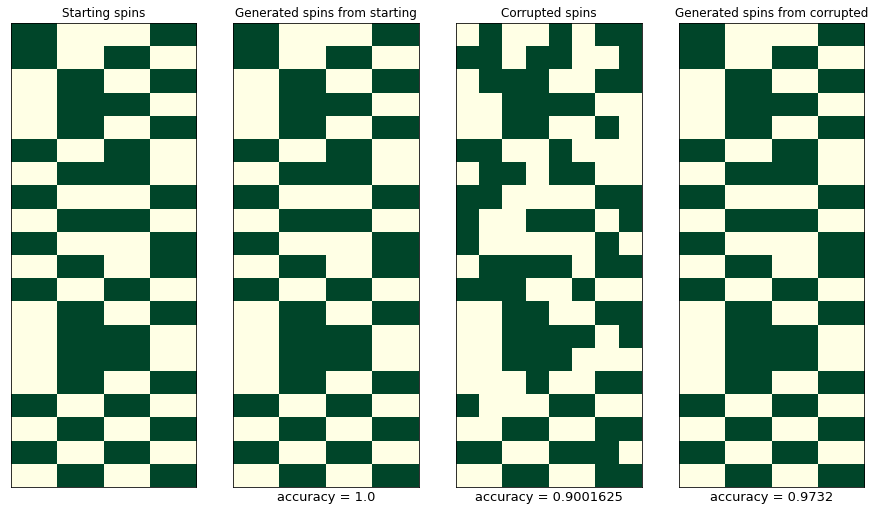

In [8]:
w, a, b, acc, dw2_corr = rbm(vc, vc0, v0, GAPv = GAPv, GAPh = GAPh, genGAPh = 64 , genGAPv =64, M = M, nepoch = 5) 
plot_result(v0,vc0,w,a,b, genGAPv = 64, genGAPh = 64)


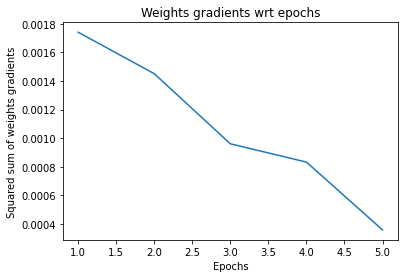

In [28]:
plt.plot(range(1,1+len(dw2_corr)),np.array(dw2_corr)/(L*M))
plt.title("Weights gradients wrt epochs")
plt.xlabel("Epochs")
plt.ylabel("Squared sum of weights gradients")

plt.show()

# Training model from clean data

Like done in the review notebook (about MNIST dataset) we try to train the model using the clean data. We will see that for q=0.1 almost nothing changes

WHAAAT?




In [29]:
accs = np.zeros((3,3,3)) #GAPv GAPh genGAPh genGAPv M
x1,x2,x3 = 0, 0, 0
GAPv_range = [1,2,4]
GAPh_range = [1,2,4]
M_range = [2,3,4]

for GAPv in GAPv_range:
    for GAPh in GAPh_range:
        for M in M_range:
            w,a,b,acc,dw2_clean = rbm(v, vc0, v0,
                            M = M,
                            l_rate = 1.0,
                            alpha = 0.05,
                            mini = 500, nepoch=5,
                            GAPv = GAPv, GAPh = GAPh, genGAPh = 64, genGAPv = 64)
            accs[x1,x2,x3]=acc
            x3 += 1
        x3=0
        x2 += 1
    x2=0
    x1 += 1
    
    

<ipython-input-3-9d1c489b2936>:33: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + exp(-DE*act))


In [30]:
GAPv_index, GAPh_index, M_index = np.array(np.where(accs == accs.max())[:])[:,0]
GAPv = GAPv_range[GAPv_index]
GAPh = GAPh_range[GAPh_index]

M = M_range[M_index]
print(f'Best parameters for accuracy {accs.min()}: GAPv = {GAPv}, GAPh = {GAPh}, M = {M}')


Best parameters for accuracy 0.96985: GAPv = 4, GAPh = 1, M = 3


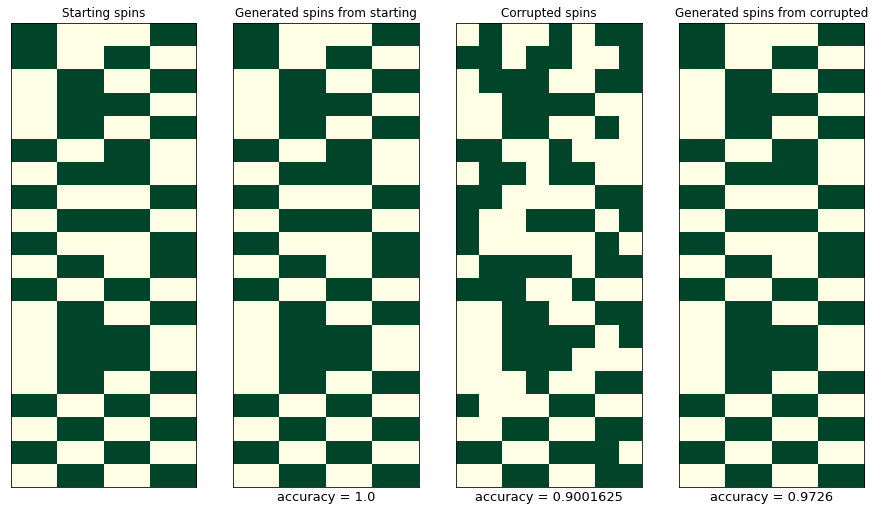

In [31]:
w, a, b, acc, dw2_clean = rbm(v, vc0, v0, GAPv = GAPv, GAPh = GAPh, genGAPh = 64 , genGAPv =64, M = M, nepoch = 5) 
plot_result(v0,vc0,w,a,b, genGAPv = 64, genGAPh = 64)


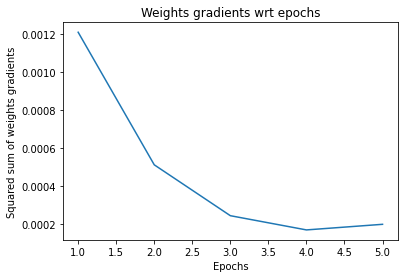

In [34]:
plt.plot(range(1,1+len(dw2_corr)),np.array(dw2_clean)/(L*M))
plt.title("Weights gradients wrt epochs")
plt.xlabel("Epochs")
plt.ylabel("Squared sum of weights gradients")

plt.show()


### Plotting best model trained from clean data with best parameters

Here the rappresentation of the network learned by the algorithm

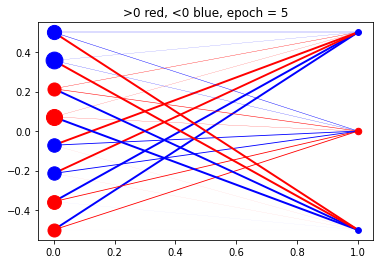

In [35]:
M = 3
(x1,y1) = create_coord(L,0)
(x2,y2) = create_coord(M,1)
plotgraph(5, w, a, b, L, M, x1, x2, y1, y2)


## Introducing State 4

We generated another set of data, adding the possibility to have the state number 4 (1,1,1,1,1,1,1,1).
As usual, we corrupted these data with a corruption rate of q=0.1 and we generated another file.

We plotted some data to check that they were properly corrupted and we computed the percentage of uncorrupted data, to check that the 90% of them maintain their original value.


In [36]:
# number of data
N=10000

# size of each data point
L=8

# corruption of bits: switch each of the L variables with probability q
rate=[0.0,0.1]

for q in rate:
    #initialize null lists
    y = [0] * N
    x = [[0] * L for j in range(N)] 

    random.seed(1234)
    for n in range(N):

        #dictionary of possible states (TRY TO PUT IT OUT OF THE LOOP)
        states = {0:[1,1,0,0,1,1,0,0],
                  1:[0,0,1,1,1,1,0,0],
                  2:[1,1,0,0,0,0,1,1],
                  3:[0,0,1,1,0,0,1,1],
                  4:[1,1,1,1,1,1,1,1]}

        key = random.randint(0,4)
        x[n] = states[key]
        y[n] = key

        #data corruption
        for j in range(L):
            if random.random()<q:
                x[n][j] = 1 - x[n][j]

    #create files
    fname = 'DATA/dataRBM_q'+str(q)+'_4.csv'
    with open(fname, mode='w') as myfile:
        writer = csv.writer(myfile, delimiter=',')
        for i in range(N):
            writer.writerow(x[i])

    #check the data
    print("q=",q)
    for n in range(10):print(x[n],y[n])

q= 0.0
[0, 0, 1, 1, 0, 0, 1, 1] 3
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1] 4
[0, 0, 1, 1, 0, 0, 1, 1] 3
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1] 4
[0, 0, 1, 1, 1, 1, 0, 0] 1
[1, 1, 1, 1, 1, 1, 1, 1] 4
q= 0.1
[0, 1, 1, 1, 1, 0, 0, 1] 3
[0, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 0, 0, 1, 0, 0, 0] 0
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 0, 1, 1, 1, 1, 0] 4
[0, 0, 1, 1, 0, 0, 1, 1] 3
[1, 1, 1, 0, 1, 1, 0, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1] 4
[0, 0, 1, 1, 1, 1, 0, 0] 1
[1, 1, 1, 1, 1, 1, 1, 1] 4


### Load the new data

In [37]:
#load clean data
q=0.0
fname='DATA/dataRBM_q'+str(q)+'_4.csv'
v = np.loadtxt(fname, delimiter = ',', dtype = int)

#load corrupted data
q=0.1
fname='DATA/dataRBM_q'+str(q)+'_4.csv'
vc = np.loadtxt(fname, delimiter = ',', dtype = int)

#True if you want to change from [0,1] to [-1,1]
SPINS = False
if SPINS:
    vmin = -1
    GAP = 2
    v = 2*v - 1
    vc = 2*vc - 1
else:
    vmin = 0
    GAP = 1
    
# store initial values
v0 = np.copy(v)
vc0 = np.copy(vc)

#print the percentage of corrupted data
mat = (v0==vc0)
perc = 0
for i in range(len(v)):perc += (mat[i]).sum()
print("Percentage of uncorrupted data:",perc*100/(N*L),"%")


Percentage of uncorrupted data: 89.945 %


Then we trained the model for different values of M and GAP, to see how the accuracies vary when varying the temperature (GAP) and the number of Hidden Neurons (M).

We trained it firstly with the corrupted data and then with the clean data.


In [43]:
#TRAINING FROM CORRUPTED DATA (LONG RUNTIME)

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_corr = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_corr1 = rbm(vc, vc0, v0,  #training the corrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_corr[j][i] = acc


In [44]:
#TRAINING FROM CLEAN DATA (LONG RUNTIME)
accuracies_clean = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_clean1 = rbm(v, vc0, v0,  #training the corrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_clean[j][i] = acc
    

<ipython-input-3-9d1c489b2936>:33: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + exp(-DE*act))


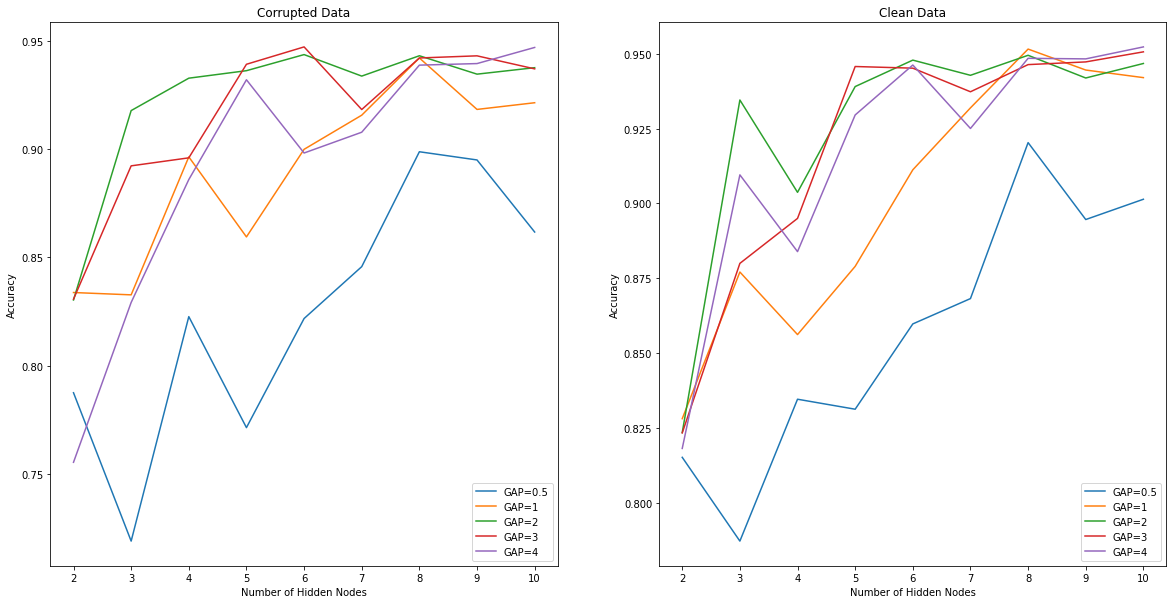

In [45]:
#plot the Variation of accuracies for different M and different temperatures
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
for i in range(len(GAP)): ax[0].plot(M,accuracies_corr[i])
ax[0].set_xlabel("Number of Hidden Nodes")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Corrupted Data")
ax[0].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

for i in range(len(GAP)): ax[1].plot(M,accuracies_clean[i])
ax[1].set_xlabel("Number of Hidden Nodes")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Clean Data")
ax[1].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

plt.show()

As we can see, when training the model with the Corrupted Data, the accuracy's behaviour it's quite unstable. In general, we observe that the higher the temperature the worse are the accuracy results. For the corrupted data trained model we reach a reasonable value for the accuracy with at least **8/9 Hidden Nodes**, not considering the GAP=0.5.

On the other hand, when training the model with clean data we easily reach a stabler behaviour of the accuracy; with just **4 Hidden Nodes** the majority of the temperatures guarantee a reasonable value of accuracy. Of course the highest temperature always behaves in a more unstable way, but eventually reaches a good accuracy level with more than 7 Hidden Nodes.

## Introducing State 5

We generated a second set of data, containing also the possibility to have state 5 (1,0,1,0,1,0,0,0) and we repeated the previous passages.


In [46]:
# number of data
N=10000

# size of each data point
L=8

# corruption of bits: switch each of the L variables with probability q
rate=[0.0,0.1]

for q in rate:
    #initialize null lists
    y = [0] * N
    x = [[0] * L for j in range(N)] 

    random.seed(1234)
    for n in range(N):

        #dictionary of possible states (TRY TO PUT IT OUT OF THE LOOP)
        states = {0:[1,1,0,0,1,1,0,0],
                  1:[0,0,1,1,1,1,0,0],
                  2:[1,1,0,0,0,0,1,1],
                  3:[0,0,1,1,0,0,1,1],
                  4:[1,1,1,1,1,1,1,1],
                  5:[1,0,1,0,1,0,0,0]}

        key = random.randint(0,5)
        x[n] = states[key]
        y[n] = key

        #data corruption
        for j in range(L):
            if random.random()<q:
                x[n][j] = 1 - x[n][j]

    #create files
    fname = 'DATA/dataRBM_q'+str(q)+'_5.csv'
    with open(fname, mode='w') as myfile:
        writer = csv.writer(myfile, delimiter=',')
        for i in range(N):
            writer.writerow(x[i])

    #check the data
    print("q=",q)
    for n in range(10):print(x[n],y[n])
    print("--------------------------")

q= 0.0
[0, 0, 1, 1, 0, 0, 1, 1] 3
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1] 4
[0, 0, 1, 1, 0, 0, 1, 1] 3
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1] 4
[0, 0, 1, 1, 1, 1, 0, 0] 1
[1, 1, 1, 1, 1, 1, 1, 1] 4
--------------------------
q= 0.1
[0, 1, 1, 1, 1, 0, 0, 1] 3
[0, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 0, 0, 1, 0, 0, 0] 0
[1, 1, 0, 0, 1, 1, 0, 0] 0
[1, 1, 0, 1, 1, 1, 1, 0] 4
[0, 0, 1, 1, 0, 0, 1, 1] 3
[1, 1, 1, 0, 1, 1, 0, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1] 4
[0, 0, 1, 1, 1, 1, 0, 0] 1
[1, 1, 1, 1, 1, 1, 1, 1] 4
--------------------------


In [63]:
#load clean data
q=0.0
fname='DATA/dataRBM_q'+str(q)+'_5.csv'
v = np.loadtxt(fname, delimiter = ',', dtype = int)

#load corrupted data
q=0.1
fname='DATA/dataRBM_q'+str(q)+'_5.csv'
vc = np.loadtxt(fname, delimiter = ',', dtype = int)

#True if you want to change from [0,1] to [-1,1]
SPINS = False
if SPINS:
    vmin = -1
    GAP = 2
    v = 2*v - 1
    vc = 2*vc - 1
else:
    vmin = 0
    GAP = 1
    
# store initial values
v0 = np.copy(v)
vc0 = np.copy(vc)

#print the percentage of corrupted data
mat = (v0==vc0)
summ = 0
for i in range(N):summ += (mat[i]).sum()
print("Percentage of uncorrupted data:",summ*100/(N*L),"%")


Percentage of uncorrupted data: 89.84 %


In [48]:
#TRAINING FROM CORRUPTED DATA (LONG RUNTIME)

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_corr = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc, dw2_corr2 = rbm(vc, vc0, v0,  #training the corrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_corr[j][i] = acc


In [49]:
#TRAINING FROM CLEAN DATA (LONG RUNTIME)

M = [2,3,4,5,6,7,8,9,10]
GAP = [0.5,1,2,3,4]

accuracies_clean = [[0] * len(M) for j in range(len(GAP))]

for j in range(len(GAP)):
    for i in range(len(M)):
        w,a,b,acc,dw2_clean2  = rbm(v, vc0, v0,  #training the corrupted data
                                M = M[i],
                                l_rate = 1.0,
                                alpha = 0.05,
                                mini = 500, nepoch=5,
                                GAPv = GAP[j], GAPh = GAP[j], genGAPh = 64, genGAPv = 64)
        accuracies_clean[j][i] = acc
    

<ipython-input-3-9d1c489b2936>:33: RuntimeWarning: overflow encountered in exp
  prob = 1. / (1. + exp(-DE*act))


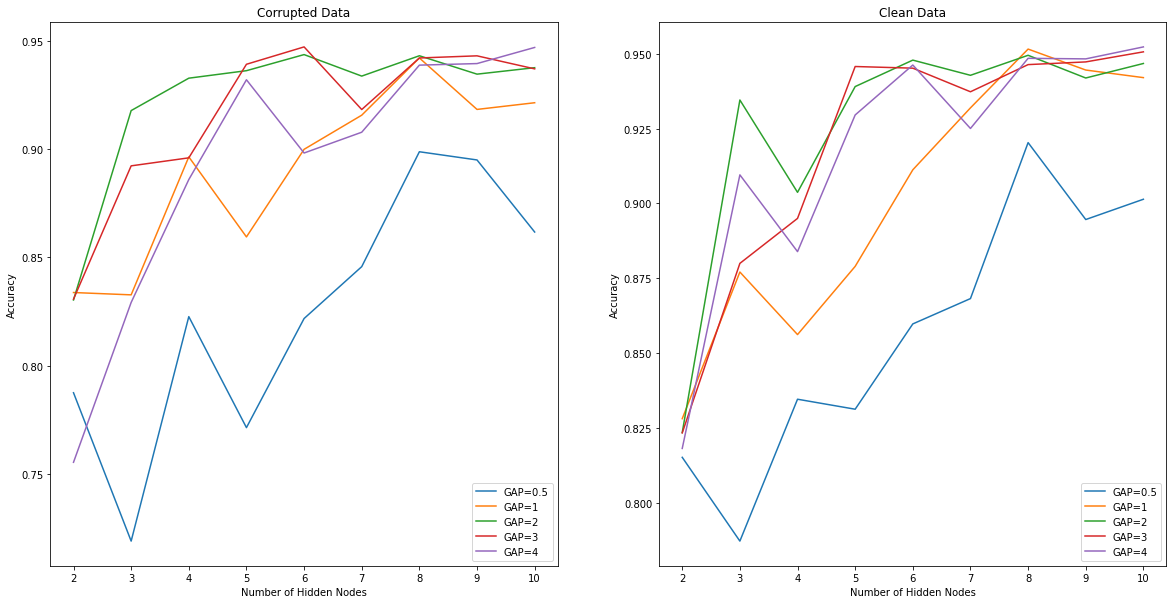

In [50]:
#plot the Variation of accuracies for different M and different temperatures
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,10))
for i in range(len(GAP)): ax[0].plot(M,accuracies_corr[i])
ax[0].set_xlabel("Number of Hidden Nodes")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Corrupted Data")
ax[0].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')

for i in range(len(GAP)): ax[1].plot(M,accuracies_clean[i])
ax[1].set_xlabel("Number of Hidden Nodes")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Clean Data")
ax[1].legend(['GAP=0.5','GAP=1','GAP=2','GAP=3','GAP=4'], loc='lower right')




plt.show()


With the data containing the state 5, the behaviours of the accuracies are a bit more unstable, but it remains true that generally lower temperatures lead to better results.

For the corrupted data trained model we reach a reasonable accuracy with at least **8 Hidden Nodes**, not considering the value corresponding to GAP=0.5. For the clean data trained model, the higher temperatures (GAP=4,3,2) reach a good accuracy with just **6 Hidden Nodes**, while the lower temperature (GAP=1) needs at least **8 Hidden Nodes**.

## What happens if we change spins value convention from {0,1} to {-1,1}?
We decide to plot how the squared sum all over rows and columns of $v$ vectors of gradients $dw$ vary by changing spins values. We notice that the results are substantially different, why does it happen?
Even though a simple convention on spins values shouldn't perturb the final result of the RBM, the latter has been built in a kind of "model dependent" way. In particular the activation function that determines if a neuron "fires" or not has been endowed with a scalar product between the weights and the spins values. It means that by using the first convention, {0,1} spins, weights corresponding to zero spins are cancelled while others are kept for the training. By choosing the second convention, {-1,1} spins, weights previously correlated to zero spins influence now the training schedule. 

In [64]:
# adding in memory first the convention {0,1} dw2 values 
M = 8
GAP = 4

accuracies_corr = [0]
w,a,b,acc, dw2_corr2 = rbm(vc, vc0, v0,
                            M = M,
                            l_rate = 1.0,
                            alpha = 0.05,
                            mini = 500, nepoch=5,
                            GAPv = GAP, GAPh = GAP, genGAPh = 64, genGAPv = 64)
accuracies_corr2 = acc

In [65]:
# let's train the model with key word argument in loading data function SPINS=TRUE. We choose also M=8 and GAP=4 to make an example.

#load clean data
q=0.0
fname='DATA/dataRBM_q'+str(q)+'_5.csv'
v = np.loadtxt(fname, delimiter = ',', dtype = int)

#load corrupted data
q=0.1
fname='DATA/dataRBM_q'+str(q)+'_5.csv'
vc = np.loadtxt(fname, delimiter = ',', dtype = int)

#True if you want to change from [0,1] to [-1,1]
SPINS = True
if SPINS:
    vmin = -1
    GAP = 2
    v = 2*v - 1
    vc = 2*vc - 1
else:
    vmin = 0
    GAP = 1
    
# store initial values
v0 = np.copy(v)
vc0 = np.copy(vc)

#print the percentage of corrupted data
mat = (v0==vc0)
summ = 0
for i in range(N):summ += (mat[i]).sum()
print("Percentage of uncorrupted data:",summ*100/(N*L),"%")

Percentage of uncorrupted data: 89.84 %


In [66]:
M = 8
GAP = 4

accuracies_corr = [0]
w,a,b,acc, dw2_corr2_new = rbm(vc, vc0, v0,
                            M = M,
                            l_rate = 1.0,
                            alpha = 0.05,
                            mini = 500, nepoch=5,
                            GAPv = GAP, GAPh = GAP, genGAPh = 64, genGAPv = 64)
accuracies_corr2_new = acc

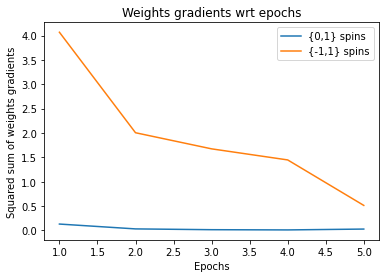

In [67]:
fig, ax = plt.subplots()
ax.plot(range(1,6),dw2_corr2, label="{0,1} spins")
ax.plot(range(1,6),dw2_corr2_new,label="{-1,1} spins")
plt.title("Weights gradients wrt epochs")
plt.xlabel("Epochs")
plt.ylabel("Squared sum of weights gradients")
ax.legend()

plt.show()

Commento finale se vuoi a proposito dei pesi pisellini 